## Data Mining

#### HW2 - 2022316101 박준우

##### Problem 1

* First separate the data matrix into the first 400 rows (training data) and last 160 rows (test data)

In [1]:
import pandas as pd

location = "HW2_dataset/bc_data.csv" #csv 파일 위치
df = pd.read_csv(location)

train_df = df.iloc[:400] #첫 400개 행을 훈련 데이터로
test_df = df.iloc[400:] #나머지 행을 테스트 데이터로

(a) Train a decision tree (with default settings) on the training data. Report the fraction
of test points that are classified correctly using the decision tree.

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


x_train = train_df.drop(columns=["id", "diagnosis"]) # 입력 데이터로 id와 diagnosis 열 제외
y_train = train_df["diagnosis"]
x_test = test_df.drop(columns=["id", "diagnosis"])
y_test = test_df["diagnosis"]

# Decision Tree로 훈련
DT = DecisionTreeClassifier(random_state=42)  # 기본 설정
DT.fit(x_train, y_train)

# test 데이터에 대해 예측 및 정확도 평가
pred = DT.predict(x_test)
accuracy = accuracy_score(y_test, pred)

print(f"Fraction of test points that are classified correctly: {accuracy}")

Fraction of test points that are classified correctly: 0.9375


* Result of fraction: 0.9375

(b) Visualize the trained decision tree. Suppose we consider a feature to be “important”
if it appears in one of the splits in the top three layers of the decision tree. Which
features are considered to be important, according to the trained tree?


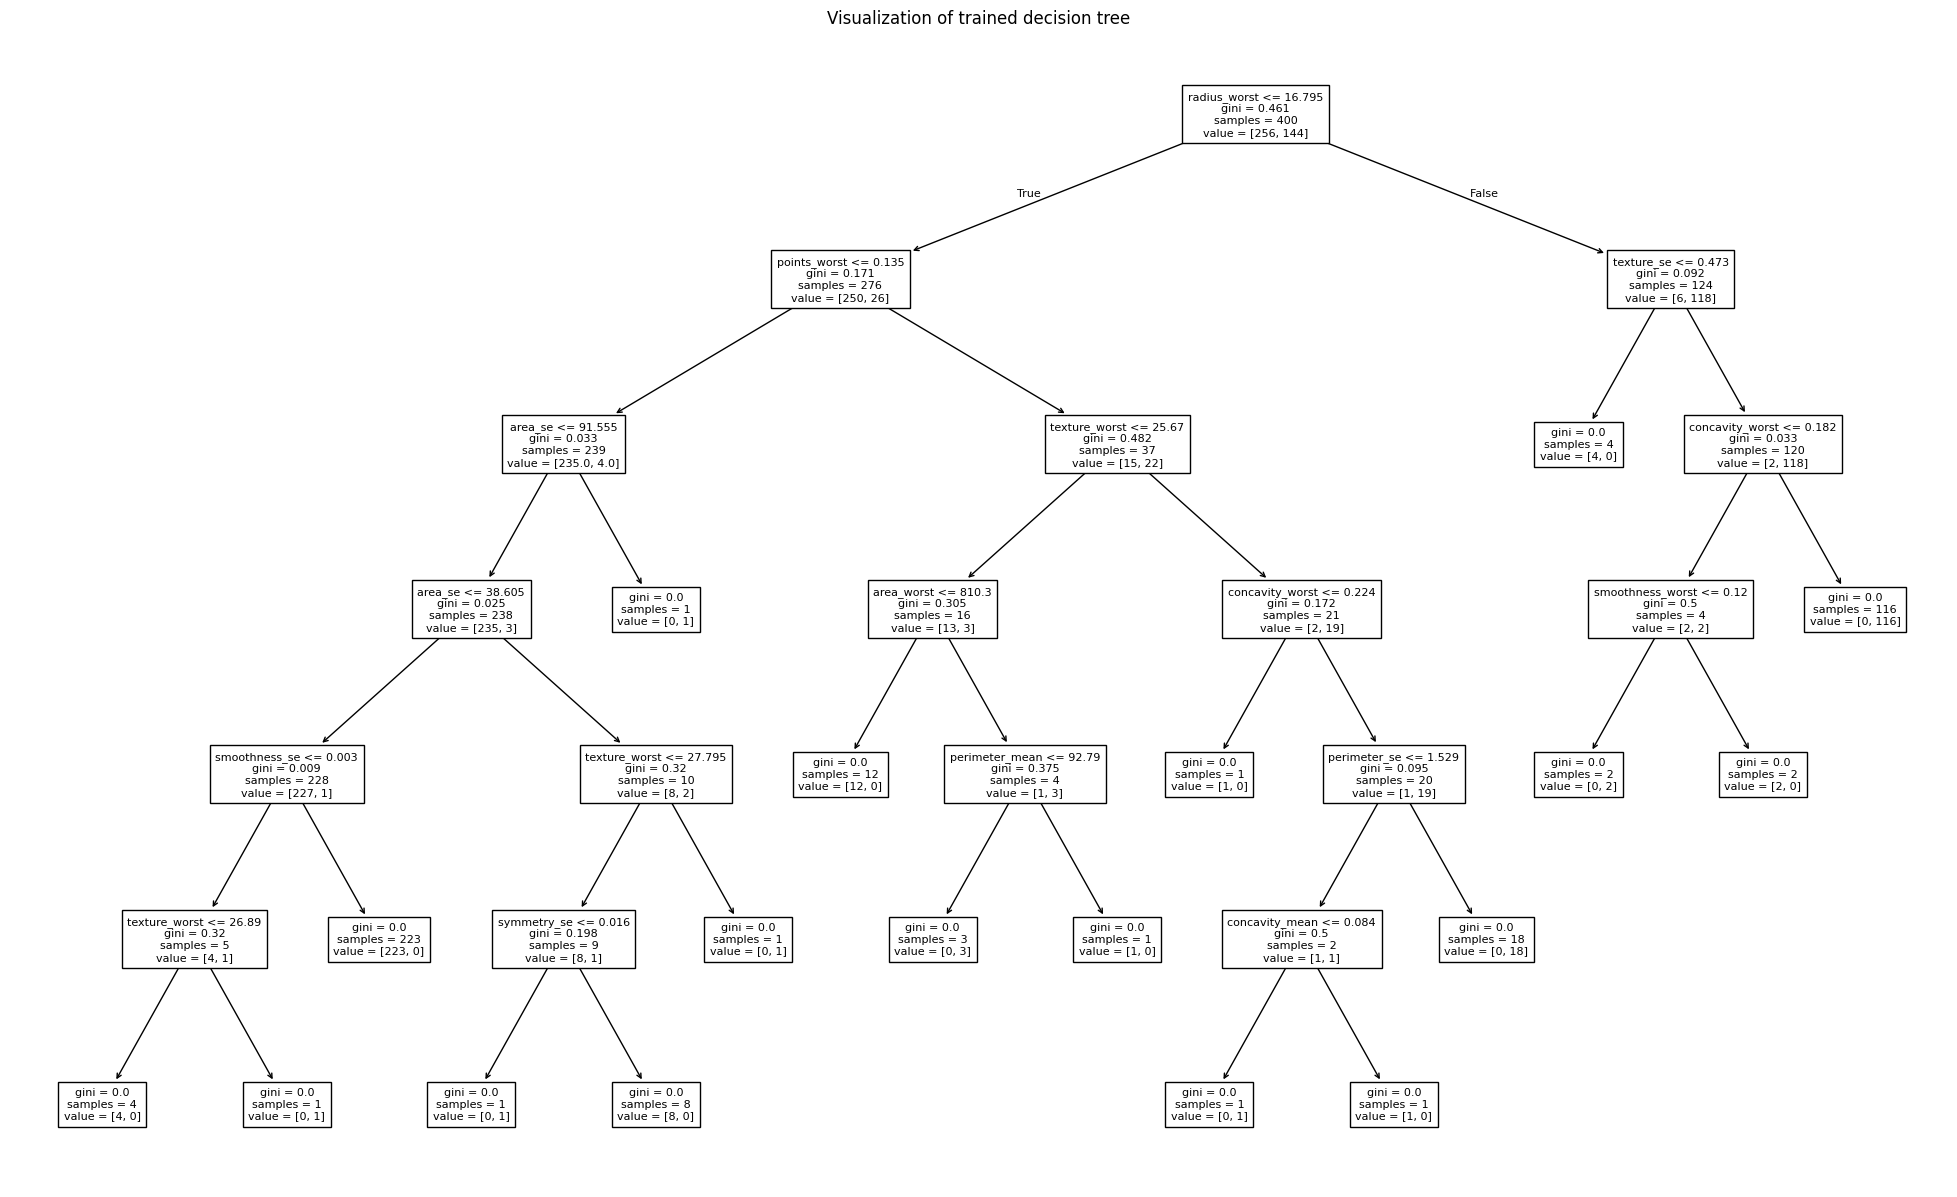

In [3]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# decision tree 시각화
plt.figure(figsize=(25, 15))
plot_tree(DT, feature_names=x_train.columns, fontsize=8)
plt.title("Visualization of trained decision tree")
plt.show()

* "radius_worst", "points_worst", "texture_se", "area_se", "texture_worst", "concavity_worst" are considered to be important according to the trained tree

(c) Now use bagging: Create an ensemble of 100 decision trees, where each tree is trained
on a bootstrapped sample of 300 data points (randomly sampled, with replacement,
from the training data set). The prediction for a test point is computed using a
majority vote among the 100 trained trees. Report the fraction of test points that are
classified correctly using the ensemble, and compare it to (a).

In [4]:
from sklearn.ensemble import BaggingClassifier

# ensemble 생성: 100 decision trees
BE = BaggingClassifier(n_estimators=100, max_samples=300, bootstrap=True, random_state=42)

# 훈련 및 예측
BE.fit(x_train, y_train)
pred = BE.predict(x_test)
accuracy = accuracy_score(y_test, pred)

print(f"Fraction of test points that are classified correctly: {accuracy}")

Fraction of test points that are classified correctly: 0.95625


* Result of fraction: 0.9562, bagging result is 0.0187 higher than single decision tree (a)

(d) Use the same criterion as in (b) to determine which features are important for each of
the 100 trees in the ensemble. What are the 5 most important features overall, ranked
according to the number of times they appear as important features among the 100
trees in the ensemble?

In [5]:
from collections import Counter

feature_names = x_train.columns.tolist()
feature_counts = {}
for feat in feature_names:
    feature_counts[feat] = 0 # feature counts 딕셔너리를 feature에 맡게 초기화

# Bagging 앙상블의 각 트리에 대해 top 3 layers에서 사용된 feature count
for tree in BE.estimators_:
    left_child = tree.tree_.children_left
    right_child = tree.tree_.children_right
    feature = tree.tree_.feature
    total_nodes = tree.tree_.node_count
    node_depth = [0] * total_nodes
    queue = [(0, 0)]

    while len(queue) > 0:
        current = queue.pop(0)
        node_id = current[0]
        depth = current[1]
        node_depth[node_id] = depth

        if left_child[node_id] != right_child[node_id]:
            queue.append((left_child[node_id], depth + 1))
            queue.append((right_child[node_id], depth + 1))

    feats = []

    # top 3 layers에서 사용됨 + 리프 노드가 아님
    for node_id in range(total_nodes):
        if node_depth[node_id] < 3 and feature[node_id] != -2:
            i = feature[node_id]
            if i not in feats:
                feats.append(i)

    for i in feats:
        name = feature_names[i]
        feature_counts[name] += 1

# feature_counts 딕셔너리에서 상위 5개 feature를 추출
sorted_list = Counter(feature_counts).most_common()
top5 = sorted_list[:5]

print(f"5 most important features (feature name, counts): {sorted_list[:5]}")

5 most important features (feature name, counts): [('points_worst', 77), ('area_se', 49), ('area_worst', 45), ('perimeter_worst', 42), ('texture_mean', 39)]


* 5 most important features are "points_worst", "area_se", "area_worst", "perimeter_worst", "texture_mean".

(e)  Instead of bagging, by using random forest, repeat the problems (c) and (d). After
obtaining the 5 most important features, compare those features with the top 5 features
resulting from the ‘feature importance’ attribute of the classifier.


In [6]:
from sklearn.ensemble import RandomForestClassifier


# 2) Random Forest 학습
RF = RandomForestClassifier(n_estimators=100, random_state=42, bootstrap=True)
RF.fit(x_train, y_train)

pred = RF.predict(x_test)
accuracy = accuracy_score(y_test, pred)
print(f"Fraction classified correctly (random forest): {accuracy}")

#(d)에서 추출했던 방식 사용
feature_names = x_train.columns.tolist()
feature_counts = {}
for feat in feature_names:
    feature_counts[feat] = 0

for tree in RF.estimators_:
    left_child = tree.tree_.children_left
    right_child = tree.tree_.children_right
    feature = tree.tree_.feature
    total_nodes = tree.tree_.node_count
    node_depth = [0] * total_nodes
    queue = [(0, 0)]

    while len(queue) > 0:
        current = queue.pop(0)
        node_id = current[0]
        depth = current[1]
        node_depth[node_id] = depth

        if left_child[node_id] != right_child[node_id]:
            queue.append((left_child[node_id], depth + 1))
            queue.append((right_child[node_id], depth + 1))

    feats = []

    for node_id in range(total_nodes):
        if node_depth[node_id] < 3 and feature[node_id] != -2:
            i = feature[node_id]
            if i not in feats:
                feats.append(i)

    for i in feats:
        name = feature_names[i]
        feature_counts[name] += 1

sorted_list = Counter(feature_counts).most_common()
top5 = sorted_list[:5]

print(f"5 most important features (feature name, counts): {sorted_list[:5]}")

Fraction classified correctly (random forest): 0.96875
5 most important features (feature name, counts): [('points_worst', 56), ('area_worst', 41), ('perimeter_worst', 38), ('radius_worst', 37), ('points_mean', 34)]


* 5 most important features in random forest are "points_worst", "area_worst", "perimeter_worst", "radius_worst", "points_mean"

* 두 방법 모두 points_worst, area_worst, perimeter_worst가 공통으로 등장했습니다.

* "area_se", "texture_mean" 는 Bagging에서만 등장했고, "radius_worst", "points_mean"는 Random Forest에서만 등장했습니다.

* 정확도는 Random Forest(0.9687) 가 Bagging(0.9562) 보다 0.0125 더 높게 나왔습니다.

##### Problem 2

(a) First, exclude ID and ZIP.code from the features. Use StandardScaler to perform
normalization to standardize the scale of all features. Split the first 4,000 records
as the training set and the remaining 1,000 records as the test set. Compare the
distribution of the target variable between the training and test sets to ensure they
are similar.

In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 데이터 로드
location = "HW2_dataset/CommonBank.csv"
df = pd.read_csv(location)

features = df.drop(['ID', 'ZIP Code'], axis=1) # 'ID'와 'ZIP Code' 삭제

# 4000, 1000개의 record를 train/test 분할
train_df = features.iloc[:4000]
test_df = features.iloc[4000:]

x_train = train_df.drop(columns=["PersonalLoan"])
y_train = train_df["PersonalLoan"]
x_test = test_df.drop(columns=["PersonalLoan"])
y_test = test_df["PersonalLoan"]

# normalize features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test) # test data scaling은 train data 이용

train_distribution = y_train.value_counts()
test_distribution = y_test.value_counts()

print("Train set에서 target variable distribution")
print(train_distribution)
print("\nTest set에서 target variable distribution")
print(test_distribution)


Train set에서 target variable distribution
PersonalLoan
0    3603
1     397
Name: count, dtype: int64

Test set에서 target variable distribution
PersonalLoan
0    917
1     83
Name: count, dtype: int64


* Train set에서는 0과 1의 비율이 약 9:1, Test set에서는 0과 1의 비율이 약 9.2:0.8로 둘이 비슷함을 확인할 수 있습니다.

(b) Apply 5-NN and analyze the results.


In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

# 5-NN 모델 학습 및 예측
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
pred = knn.predict(x_test)

# 평가 지표 출력
accuracy = accuracy_score(y_test, pred)
cm = confusion_matrix(y_test, pred)
cr = classification_report(y_test, pred)

print(f"Accuracy(5-NN): {accuracy}")
print("Result")
print(cr)
print("Confusion Matrix")
print(cm)

Accuracy(5-NN): 0.962
Result
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       917
           1       0.92      0.59      0.72        83

    accuracy                           0.96      1000
   macro avg       0.94      0.79      0.85      1000
weighted avg       0.96      0.96      0.96      1000

Confusion Matrix
[[913   4]
 [ 34  49]]


* 전체 정확도는 0.962로 매우 높습니다.

* 0과 1 class에 대한 preicison도 0.96, 0.92로 높습니다.

* 그러나 class 0에 대한 recall은 1.00으로 실제로 0인 고객 전부를 0으로 맞췄지만, class 1에 대한 recall은 0.59로 실제로 1인 고객을 정확하게 맞출 확률은 낮게 나왔습니다.

* 즉, False Negative가 34명으로 대출 가입할 확률이 높은 고객을 놓칠 수도 있습니다.

(c) Use the last 800 records of the training set as a validation set. Apply k-NN with
various values of k and compare prediction performance. Which value of k provides
the best model performance?


In [9]:
# 훈련 데이터 중 마지막 800개를 검증용으로 분리
train_split = train_df.iloc[:3200]
val_split = train_df.iloc[3200:]

x_train_split = train_split.drop(columns=["PersonalLoan"])
y_train_split = train_split["PersonalLoan"]
x_val_split = val_split.drop(columns=["PersonalLoan"])
y_val_split = val_split["PersonalLoan"]

scaler = StandardScaler()
x_train_split = scaler.fit_transform(x_train_split)
x_val_split = scaler.transform(x_val_split)

k_values = [1, 3, 5, 7, 9, 11, 13] # various values of k
k_result    = []
acc_result  = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train_split, y_train_split)
    pred = knn.predict(x_val_split)
    accuracy = accuracy_score(y_val_split, pred)
    
    k_result.append(k)
    acc_result.append(accuracy)

print("k 값별 Accuracy")
for k, acc in zip(k_result, acc_result):
    print(f"k = {k}: {acc}")

k 값별 Accuracy
k = 1: 0.955
k = 3: 0.9475
k = 5: 0.95125
k = 7: 0.94375
k = 9: 0.94625
k = 11: 0.93875
k = 13: 0.9375


* 다양한 k 값(1,3,5,7,9,11,13)을 적용해봤을 때, k = 1 이 0.955으로 제일 높은 성능을 보였습니다

(d) Perform 5-fold cross-validation on the training set, repeated five times, to find the best
k value. Use this best k value to create the final model and apply it to the test set.
Report the model’s performance.


In [10]:
from sklearn.model_selection import RepeatedKFold, cross_val_score

k_values = [1, 3, 5, 7, 9, 11, 13]
k_result    = []
acc_result  = []
kf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    accuracy = cross_val_score(knn, x_train, y_train, cv=kf, scoring='accuracy')
    acc = accuracy.mean()
    k_result.append(k)
    acc_result.append(acc)

print("k 값별 Accuracy")
for k, acc in zip(k_result, acc_result):
    print(f"k = {k}: {acc}")


k 값별 Accuracy
k = 1: 0.9538500000000001
k = 3: 0.95765
k = 5: 0.9561499999999999
k = 7: 0.95285
k = 9: 0.9505
k = 11: 0.9488500000000001
k = 13: 0.9466


* best k value: 3

In [11]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)
pred = knn.predict(x_test)

accuracy = accuracy_score(y_test, pred)
cm = confusion_matrix(y_test, pred)
cr = classification_report(y_test, pred)

print(f"Accuracy(3-NN): {accuracy}")
print("Result")
print(cr)
print("Confusion Matrix")
print(cm)

Accuracy(3-NN): 0.967
Result
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       917
           1       0.93      0.65      0.77        83

    accuracy                           0.97      1000
   macro avg       0.95      0.82      0.87      1000
weighted avg       0.97      0.97      0.96      1000

Confusion Matrix
[[913   4]
 [ 29  54]]


* Report of model performance when k is 3

class 0: Precision 0.97, Recall 1.00, F1-score 0.98

class 1: Precision 0.93, Recall 0.65, F1-score 0.77

Accuracy: 0.967, average F1: 0.87

True Negative: 913

False Positive: 4

False Negative: 29

True Positive: 54

(e) Compare the advantages and disadvantages of the training methods used in steps 3
and 4.


* Advantages of Hold-out validation (step3)
1. 고정된 train/valid 데이터에 대해서 실험하기에 메모리 부담이 적고 계산 속도가 빠릅니다.
2. RepeatedKFold와 같은 라이브러리를 호출할 필요가 없기에 구현이 더 단순합니다.


* Disadvantages of Hold-out validation (step3)
1. train/valid가 어떻게 나누어지느냐에 따라서 결과가 크게 달라질 수 있습니다.
2. 실제 train 학습에 사용 가능한 데이터는 4000개가 아닌 3200개로 줄어듭니다.

* Advantages of repeated k-fold cross-validation (step4)
1. 여러 번 반복해서 train/valid 데이터를 다르게 설정해서 학습/평가하기에, 결과가 안정적입니다.
2. 총 4000개의 데이터를 매 fold마다 분할되어 학습용/검증용으로 들어가기에 단일 홀드아웃보다 더 많은 데이터를 학습에 사용합니다.

* Disadvantages of repeated k-fold cross-validation (step4)
1. repeated k-fold 일 경우 k*n 회만큼 반복해서 학습/평가해야 하므로 계산 시간이 오래 걸립니다.
2. RepeatedKFold와 같은 라이브러리를 호출해야 하기에 구현이 조금 더 복잡합니다.

##### Problem 3

1.  Calculate the number of movies included in each genre. Which genre includes the most
movies, and which includes the fewest? Then, calculate the average number of genres
a movie belongs to. Identify the movie(s) that belong to the highest number of genres.
How many genres does this movie belong to?

In [12]:
location = "HW2_dataset/movie.csv" #csv 파일 위치
df = pd.read_csv(location, encoding='ISO-8859-1')

genre = df.columns.tolist()
genre.remove('Title')
#genre.remove("Unknown") #

genre_count = df[genre].sum()

print("Number of movies included in each genre")
print(genre_count)

# genre which includes the most movies, and the least movies
max_genre_count = genre_count.max()
min_genre_count = genre_count.min()
max_genre = genre_count[genre_count == max_genre_count].index
min_genre = genre_count[genre_count == min_genre_count].index

print(f"Genre which includes the most movies: {max_genre}")
print(f"Genre which includes the fewest movies: {min_genre}")

df['num_genres'] = df[genre].sum(axis=1) # 한 영화가 속한 장르의 개수를 위한 열 생성
average_genre = df['num_genres'].mean()
print(f"Average number of genres a movie belongs to: {average_genre}")

# movies that belong to the highest number of genres
max_movie = df[df['num_genres'] == df['num_genres'].max()]['Title']
count = df['num_genres'].max()

print("Movies that belong to the highest number of genres")
for title in max_movie:
    print(f"{title}")
print(f"Number of genres: {count}")
    

Number of movies included in each genre
Unknown          2
Action         249
Adventure      133
Animation       42
Childrens      120
Comedy         502
Crime          107
Documentary     50
Drama          716
Fantasy         22
FilmNoir        24
Horror          90
Musical         56
Mystery         60
Romance        244
SciFi          100
Thriller       248
War             71
Western         27
dtype: int64
Genre which includes the most movies: Index(['Drama'], dtype='object')
Genre which includes the fewest movies: Index(['Unknown'], dtype='object')
Average number of genres a movie belongs to: 1.7205528846153846
Movies that belong to the highest number of genres
Empire Strikes Back, The (1980)
Transformers: The Movie, The (1986)
Kid in King Arthur's Court, A (1995)
Number of genres: 6


* Genre which includes the most movies: Drama
* Genre which includes the fewest movies: Unknown, Unknown 제외 시 Fantasy
* Average number of genres a movie belongs to: 1.7
* Movie(s) with the highest number of genres: "Empire Strikes Back, The (1980)", "Transformers: The Movie, The (1986)", "Kid in King Arthur's Court, A (1995)"
* Number of genre above movie(s) belong to: 6

2. Use hierarchical clustering to group movies with similar genres. Follow the steps
below

(a) Perform clustering using three linkage criteria: average, complete, and single
linkage. Visualize the dendrogram for each case.


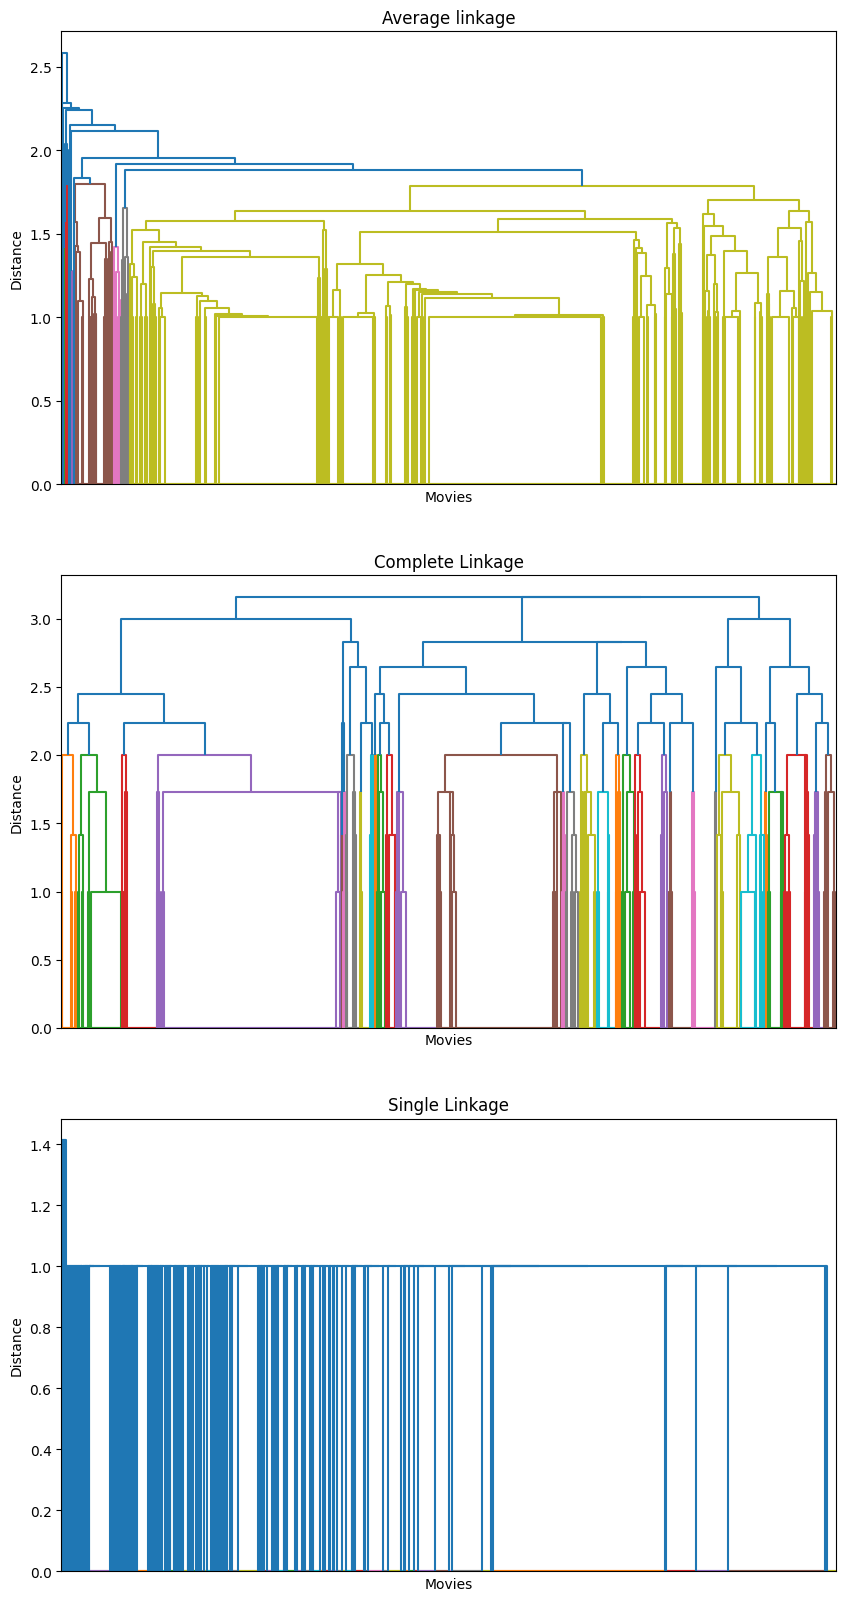

In [13]:
from scipy.cluster.hierarchy import linkage, dendrogram

genre_features = df[genre].values

fig = plt.figure(figsize=(10, 20))

# Average linkage
ax1 = fig.add_subplot(3, 1, 1)
AL = linkage(genre_features, method='average')
dendrogram(AL, ax=ax1, no_labels=True)
ax1.set_title("Average linkage")
ax1.set_xlabel("Movies")
ax1.set_ylabel("Distance")

# Complete linkage
ax2 = fig.add_subplot(3, 1, 2)
CL = linkage(genre_features, method='complete')
dendrogram(CL, ax=ax2, no_labels=True)
ax2.set_title("Complete Linkage")
ax2.set_xlabel("Movies")
ax2.set_ylabel("Distance")

# Single linkage
ax3 = fig.add_subplot(3, 1, 3)
SL = linkage(genre_features, method='single')
dendrogram(SL, ax=ax3, no_labels=True)
ax3.set_title("Single Linkage")
ax3.set_xlabel("Movies")
ax3.set_ylabel("Distance")

plt.show()

(b) Compare the shapes of the three dendrograms. What characteristics do they
exhibit? How do the ranges of height values differ for the three cases, and what
causes these differences?


* Average linkage: 클러스터끼리 병합하는 기준이 "두 클러스터의 모든 쌍의 거리의 평균" 이기 때문에 single linkage와 complete linkage의 중간 느낌으로 병합 분포가 왼쪽에서 오른쪽으로 완만하게 내려옵니다.
* Complete linkage: 병합하는 기준이 "두 클러스터의 모든 쌍 중 최대 거리" 이기 때문에 거리가 1일 때부터 병합되기 시작하고, 클러스터간의 거리가 상대적으로 높으며, 거리에 따라 클러스터들이 고르게 병합됩니다.
* Single linkage: 병합하는 기준이 "클러스터 간의 최소 거리"이기 때문에 클러스터 간의 최대 거리가 약 1.4고 거리가 1 이하에서 병합이 많이 일어납니다.

* Single linkage는 높이가 낮은 편, average linkage는 중간, complete linkage는 높은 편입니다.

* Single linkage는 두 클러스터의 최소 거리를 기준으로 병합하기에, 거리가 가장 작은 값들부터 시작해서 덴드로그램을 형성하므로 높이의 분포가 낮습니다.
* Average linkage는 두 클러스터의 쌍들의 평균 거리를 기준으로 병합하기에, single linkage와 complete linkage의 중간 경향을 나타냅니다. 최종 높이도 두 linkage의 사이(1.4~3.2)에 위치합니다.
* Complete linkage는 두 클러스터 쌍들 중 최대 거리를 기준으로 하기에, 덴드로그램에서 다른 linkage에 비해 상대적으로 높이가 높습니다. 최대 병합 거리도 약 3.2로 제일 큽니다.

(c) Create 10 clusters for each linkage criterion. Compare the distribution of the
number of movies in each cluster for the three cases.

In [14]:
from scipy.cluster.hierarchy import fcluster

# 10개의 클러스터 생성
cluster_AL = fcluster(AL, t=10, criterion='maxclust')
cluster_CL = fcluster(CL, t=10, criterion='maxclust')
cluster_SL = fcluster(SL, t=10, criterion='maxclust')

count_AL = pd.Series(cluster_AL).value_counts()
count_CL = pd.Series(cluster_CL).value_counts()
count_SL = pd.Series(cluster_SL).value_counts()

# 편리하게 보기 위해 DataFrame으로 변환
cluster_counts_df = pd.DataFrame({
    'Average linkage': count_AL,
    'Complete linkage': count_CL,
    'Single linkage': count_SL
})

print("Number of movies in each cluster for the three cases")
print(cluster_counts_df)


Number of movies in each cluster for the three cases
   Average linkage  Complete linkage  Single linkage
1              2.0             602.0               2
2              3.0               9.0            1655
3              3.0              59.0               1
4              8.0             444.0               1
5              2.0              90.0               1
6              7.0             200.0               1
7           1638.0             106.0               1
8              1.0             154.0               1
9              NaN               NaN               1


* Average linkage: 클러스터 크기가 single linkage보다는 고르게, complete linkage보다는 밀집되어 있는 모습을 보입니다.
* Complete linkage: 100개, 200개, 400개 등 비교적으로 고르게 분포되어 있습니다.
* Single linkage: 대부분의 영화가 2번 클러스터에 모여있고, 나머지 클러스터에는 영화가 1개 혹은 2개만 존재합니다.

3. Use k-means clustering to group movies with similar genres. Follow the steps below

(a) Since the performance of k-means depends on the initial cluster configuration,
run k-means multiple times with different starting points. Run k-means with
‘n_init’ set to 10, 100, and 1000, and compare the objective function values
(within-cluster sum of squares) for each case. Set the number of clusters k = 10.
Use a fixed random seed (random_state=123) for reproducibility

In [16]:
from sklearn.cluster import KMeans

n_init = [10, 100, 1000]
sum_of_squares = [] # objective function value

for init in n_init:
    km = KMeans(n_clusters=10, n_init=init, random_state=123)
    km.fit(genre_features)
    sum_of_squares.append(km.inertia_)

for i in range(len(n_init)):
    n_init_value = n_init[i]
    sum_of_squares_value = sum_of_squares[i]
    print(f"n_init = {n_init_value}, objective function value = {sum_of_squares_value:.2f}")

n_init = 10, objective function value = 906.52
n_init = 100, objective function value = 894.85
n_init = 1000, objective function value = 894.85


(b) Using the solution obtained with n_init = 1000: Analyze the distribution of the
number of movies in each cluster. Compare this distribution to the results from
2-(c) (Hierarchical Clustering).


In [19]:
n_init = 1000
km = KMeans(n_clusters=10, n_init=n_init, random_state=123)
km.fit(genre_features)

km_cluster = pd.Series(km.labels_).value_counts()
print("Distribution of the number of movies in each cluster (K-means)")
print(km_cluster)

Distribution of the number of movies in each cluster (K-means)
1    475
4    295
2    176
3    156
0    146
9     97
5     85
6     84
8     78
7     72
Name: count, dtype: int64


* 각 cluster 내의 영화들의 개수가 70개부터 시작해 475개 까지 다양하게 분포되어있는데, hierarchical clustering 기법보다 더 균등하게 영화들이 분포되어있는 것을 확인할 수 있습니다.

(c) For each cluster, calculate the proportion of movies belonging to each genre.
Based on the results, analyze the dominant genre(s) in each cluster and the
characteristics of each cluster.

In [20]:
df['cluster'] = km.labels_  # 각 영화가 속한 클러스터를 dataframe에 추가

movie_proportion = df.groupby('cluster')[genre].mean()

print("Proportion of movies belonging to each genre in each cluster")
print(movie_proportion)

Proportion of movies belonging to each genre in each cluster
          Unknown    Action  Adventure  Animation  Childrens    Comedy  \
cluster                                                                  
0        0.000000  0.061644   0.020548   0.006849   0.000000  0.013699   
1        0.000000  0.052632   0.008421   0.000000   0.025263  0.000000   
2        0.000000  1.000000   0.375000   0.011364   0.028409  0.056818   
3        0.012821  0.000000   0.089744   0.019231   0.000000  0.000000   
4        0.000000  0.050847   0.003390   0.013559   0.094915  1.000000   
5        0.000000  0.023529   0.023529   0.011765   0.011765  1.000000   
6        0.000000  0.095238   0.000000   0.000000   0.000000  0.142857   
7        0.000000  0.055556   0.555556   0.430556   1.000000  0.125000   
8        0.000000  0.038462   0.012821   0.000000   0.025641  1.000000   
9        0.000000  0.072165   0.020619   0.000000   0.000000  0.113402   

            Crime  Documentary     Drama   Fantasy

In [28]:
# dominent genre in each cluster
print("Top 3 dominent genres in each cluster")
for index in movie_proportion.index:
    order = movie_proportion.loc[index].sort_values()
    top3 = order.iloc[-3:]
    
    print(f"Cluster {index}: {top3.index.tolist()}")  # 상위 3개 장르 출력

Top 3 dominent genres in each cluster
Cluster 0: ['Crime', 'Drama', 'Thriller']
Cluster 1: ['War', 'Crime', 'Drama']
Cluster 2: ['Adventure', 'Thriller', 'Action']
Cluster 3: ['Crime', 'Romance', 'Documentary']
Cluster 4: ['Action', 'Childrens', 'Comedy']
Cluster 5: ['Musical', 'Romance', 'Comedy']
Cluster 6: ['Comedy', 'Thriller', 'Horror']
Cluster 7: ['Animation', 'Adventure', 'Childrens']
Cluster 8: ['Crime', 'Comedy', 'Drama']
Cluster 9: ['Comedy', 'Drama', 'Romance']


* cluster 0에 속한 모든 영화는 Thriller 장르를 가지고 있습니다. (proportion: 1.0)
* cluster 1에 속한 모든 영화는 Drama 장르를 가지고 있습니다. (proportion: 1.0)
* cluster 2에 속한 모든 영화는 Action 장르를 가지고 있습니다. (proportion: 1.0)
* cluster 3는 Documentary 장르를 가진 영화의 비중이 높으나, 그 외에 다른 장르도 고르게 섞여있어 장르가 혼합되어있습니다.
* cluster 4에 속한 모든 영화는 Comedy 장르를 가지고 있습니다. (proportion: 1.0)
* cluster 5에 속한 모든 영화는 Romance와 Comedy 장르를 동시에 가지고 있습니다. (proportion: 1.0)
* cluster 6에 속한 모든 영화는 Horror 장르를 가지고 있습니다. (proportion: 1.0)
* cluster 7에 속한 모든 영화는 Childrens 장르를 가지고 있습니다. (proportion: 1.0)
* cluster 8에 속한 모든 영화는 Comedy와 Drama 장르를 동시에 가지고 있습니다. (proportion: 1.0)
* cluster 9에 속한 모든 영화는 Romance와 Drama 장르를 동시에 가지고 있습니다. (proportion: 1.0)

(d) A user has rated the movie “Titanic (1997)” with 5 stars. Recommend 5 movies
with similar genres. Identify which cluster “Titanic (1997)” belongs to. Recommend
5 movies from the same cluster.

In [77]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


# recommend 5 movies with similar genre based on consine similarity
titanic = (df['Title'] == "Titanic (1997)")

titanic_vec = df.loc[titanic, genre].values.reshape(1, -1)

titanic_sim = cosine_similarity(titanic_vec, genre_features).flatten()
titanic_sim = pd.Series(titanic_sim)

sorted_idx = titanic_sim.sort_values(ascending=False).index.tolist()
top5_sim = sorted_idx[1:6]

print("5 movies with similar genre to Titanic (1997)")
rank = 1
for i in top5_sim:
    title = df.loc[i, 'Title']
    score = titanic_sim[i]
    print(f"{rank}: {title} (score: {score:.3f})")
    rank += 1
    

5 movies with similar genre to Titanic (1997)
1: Man in the Iron Mask, The (1998) (score: 1.000)
2: Cyrano de Bergerac (1990) (score: 1.000)
3: First Knight (1995) (score: 0.866)
4: Crying Game, The (1992) (score: 0.866)
5: Somewhere in Time (1980) (score: 0.816)


In [72]:
import random

#recommend 5 movies from the same cluster
titanic_idx = df.index[titanic][0]

titanic_cluster = df.loc[titanic_idx, 'cluster']
print(f"Cluster which \"Titanic (1997)\" belongs to: {titanic_cluster}")


same_cluster = df.index[df['cluster'] == titanic_cluster].tolist()
reccomend = random.sample(same_cluster, 5)

print(f"\n5 movies recommended from the same cluster")
rank = 1
for i in reccomend:
    title = df.loc[i, 'Title']
    print(f"{rank}. {title}")
    rank += 1

Cluster which "Titanic (1997)" belongs to: 14

5 movies recommended from the same cluster
1. Shadowlands (1993)
2. What Happened Was... (1994)
3. Cinema Paradiso (1988)
4. Jane Eyre (1996)
5. I Like It Like That (1994)


(e) Repeat the analysis (c)-(d) for different numbers of clusters k = 5 and k = 20.
Compare the results for k = 10, k = 5, and k = 20. Discuss how the number of
clusters affects the recommendation system.


* k = 5

In [73]:
# analysis when k = 5
km = KMeans(n_clusters=5, n_init=n_init, random_state=123)
km.fit(genre_features)

# (c) when k = 5
df['cluster'] = km.labels_ 

movie_proportion = df.groupby('cluster')[genre].mean()

print("Proportion of movies belonging to each genre in each cluster")
print(movie_proportion)
print("\nTop 3 dominent genres in each cluster")
for index in movie_proportion.index:
    order = movie_proportion.loc[index].sort_values()
    top3 = order.iloc[-3:]
    
    print(f"Cluster {index}: {top3.index.tolist()}")  
    

# (d) when k = 5
titanic = (df['Title'] == "Titanic (1997)")
    
titanic_idx = df.index[titanic][0]

titanic_cluster = df.loc[titanic_idx, 'cluster']
print(f"\nCluster which \"Titanic (1997)\" belongs to: {titanic_cluster}")


same_cluster = df.index[df['cluster'] == titanic_cluster].tolist()
reccomend = random.sample(same_cluster, 5)

print(f"\n5 movies recommended from the same cluster")
rank = 1
for i in reccomend:
    title = df.loc[i, 'Title']
    print(f"{rank}. {title}")
    rank += 1

Proportion of movies belonging to each genre in each cluster
          Unknown    Action  Adventure  Animation  Childrens    Comedy  \
cluster                                                                  
0        0.000000  0.037113   0.016495   0.020619   0.082474  1.000000   
1        0.007782  0.000000   0.151751   0.108949   0.210117  0.000000   
2        0.000000  0.051418   0.015957   0.000000   0.030142  0.000000   
3        0.000000  1.000000   0.368159   0.014925   0.044776  0.064677   
4        0.000000  0.006369   0.019108   0.006369   0.000000  0.025478   

            Crime  Documentary     Drama   Fantasy  FilmNoir    Horror  \
cluster                                                                  
0        0.024742     0.002062  0.181443  0.014433  0.000000  0.022680   
1        0.066148     0.178988  0.000000  0.027237  0.031128  0.182879   
2        0.054965     0.005319  1.000000  0.005319  0.003546  0.008865   
3        0.084577     0.000000  0.064677  0.019900

k = 20

In [74]:
# analysis when k = 20
km = KMeans(n_clusters=20, n_init=n_init, random_state=123)
km.fit(genre_features)

# (c) when k = 20
df['cluster'] = km.labels_ 

movie_proportion = df.groupby('cluster')[genre].mean()

print("Proportion of movies belonging to each genre in each cluster")
print(movie_proportion)
print("\nTop 3 dominent genres in each cluster")
for index in movie_proportion.index:
    order = movie_proportion.loc[index].sort_values()
    top3 = order.iloc[-3:]
    
    print(f"Cluster {index}: {top3.index.tolist()}")  
    

# (d) when k = 20
titanic = (df['Title'] == "Titanic (1997)")
    
titanic_idx = df.index[titanic][0]

titanic_cluster = df.loc[titanic_idx, 'cluster']
print(f"\nCluster which \"Titanic (1997)\" belongs to: {titanic_cluster}")


same_cluster = df.index[df['cluster'] == titanic_cluster].tolist()
reccomend = random.sample(same_cluster, 5)

print(f"\n5 movies recommended from the same cluster")
rank = 1
for i in reccomend:
    title = df.loc[i, 'Title']
    print(f"{rank}. {title}")
    rank += 1

Proportion of movies belonging to each genre in each cluster
          Unknown    Action  Adventure  Animation  Childrens    Comedy  \
cluster                                                                  
0        0.000000  0.000000   0.000000   0.000000   0.000000  0.000000   
1        0.000000  0.027027   0.013514   0.000000   0.027027  1.000000   
2        0.000000  0.000000   0.011765   0.011765   0.000000  0.058824   
3        0.000000  0.000000   0.004049   0.012146   0.000000  1.000000   
4        0.000000  0.000000   0.062500   1.000000   0.937500  0.156250   
5        0.000000  1.000000   0.328358   0.000000   0.044776  0.000000   
6        0.000000  0.033573   0.009592   0.000000   0.028777  0.000000   
7        0.033898  0.000000   0.067797   0.000000   0.000000  0.000000   
8        0.000000  0.059701   0.000000   0.000000   0.000000  0.164179   
9        0.000000  0.000000   0.000000   0.000000   0.000000  1.000000   
10       0.000000  1.000000   0.240000   0.000000  

* 클러스터 개수 k 가 적을수록 하나의 클러스터에 속한 영화의 개수가 많아지기 때문에, 추천 목록에는 Titanic 영화와 조금 동떨어진 영화를 추천할 수도 있습니다. 예시로 k = 5 일때 Titanic이 속한 cluster 2에는 War 이라는 장르가 0.05 로 상대적으로 높은 비율로 포함되어있는 것을 확인할 수 있습니다. 
* k= 10, k = 20일 때 모두 Titanic이 속한 cluster에 'Romance', 'Drama', 'Comedy' 순으로 장르가 점유하고 있고, 그로 인해 추천 시스템도 Titanic과 비슷한 장르의 영화를 추천하는 것을 볼 수 있습니다. 하지만 클러스터가 더욱 많아지게 된다면 한 클러스터 내에서 추천가능한 영화의 수가 줄어들 수 있습니다.

##### Problem 4

Content-based filtering relies on the features (attributes) of items to make recommendations.
Instead of looking at user interactions like ratings or clicks, it identifies
similarities between items based on their attributes. Use the genre feature matrix to
calculate the pairwise cosine similarity between movies. Assume a user has rated the
movie “Titanic (1997)” with 5 stars and “Twelve Monkeys (1995)” with 1 star. Based
on the cosine similarity, recommend 5 movies to this user.


In [85]:
titanic = (df['Title'] == "Titanic (1997)")
twelve_monkeys = (df['Title'] == "Twelve Monkeys (1995)")

titanic_vec = df.loc[titanic, genre].values.reshape(1, -1)
twelve_monkeys_vec = df.loc[twelve_monkeys, genre].values.reshape(1, -1)

# attribute 간의 cosine similarity 계산
sim_titanic = cosine_similarity(titanic_vec, genre_features).flatten()
sim_tm = cosine_similarity(twelve_monkeys_vec,      genre_features).flatten() 

score = sim_titanic - sim_tm # 추천 score = Titanic similarity − Twelve Monkeys similarity

score = pd.Series(score)
sorted_idx = score.sort_values(ascending=False).index.tolist()
top5_idx = sorted_idx[:5] 


print("Content-based filtering result")
rank = 1
for i in top5_idx:
    title = df.loc[i, 'Title']
    print(f"{rank}. {title} (score: {score[i]:.3f})")
    rank += 1

Content-based filtering result
1. Top Gun (1986) (score: 0.816)
2. Days of Thunder (1990) (score: 0.816)
3. Truth or Consequences, N.M. (1997) (score: 0.667)
4. Cutthroat Island (1995) (score: 0.667)
5. Last of the Mohicans, The (1992) (score: 0.667)
